In [1]:
import sys
import shapely
from shapely.geometry import box, MultiPolygon, LineString, Point, MultiLineString, Polygon
import math
import matplotlib.pyplot as plt
import numpy as np
%matplotlib inline

from gridmap import OccupancyGridMap
import matplotlib.pyplot as plt
from a_star import a_star
from utils import plot_path
from sklearn import preprocessing
import pandas as pd
from tqdm import tqdm

from sklearn.ensemble import RandomForestClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.svm import SVC
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import f1_score, make_scorer
from sklearn.model_selection import cross_val_score, train_test_split
import random
from tqdm import tqdm
import imageio

import warnings
warnings.filterwarnings('ignore')

In [2]:
num_points_on_circ = 4
pi = math.pi
def PointsInCircum(r,n=num_points_on_circ, center = (0,0)):
    return np.array([(center[0] + math.cos(2*pi/n*x)*r, center[1] + math.sin(2*pi/n*x)*r) for x in range(0,n+1)])

In [3]:
def gen_shapely_map(map_size, obstacles):
    '''
    Given map_size and list of obstacles where
    an obstacle is described by a tuple (xmin, ymin, xmax, ymax),
    create a shapely map. 
    '''
    
    pols = [box(0,0,map_size[0], map_size[1])]
    for obstacle in obstacles:
        pols.append(box(*obstacle))
    lines = []
    for pol in pols:
        boundary = pol.boundary
        if boundary.type == 'MultiLineString':
            for line in boundary:
                lines.append(line)
        else:
            lines.append(boundary)

    MAP = MultiLineString(lines)
    return MAP

def get_map_arr(MAP_params, shape):
    '''
    Convert the shapely obstacles into a numpy grid
    for use with the A* planner. 
    
    MAP_params is of the form [(xmin, ymin, xmax, ymax), (xmin, ymin, xmax, ymax), ...]
    describing each rectangular obstacle in the map. Currently only supports rectangles. 
    
    Shape is just a tuple with the map size. 
    
    '''
    map_np = np.zeros(shape)
    for param in MAP_params:
        xmin, ymin, xmax, ymax = param
        map_np[ymin:ymax, xmin:xmax] = 1
        
    return map_np

In [4]:
# Mapping from label encoder (just hard coded it here)
dirs = {0:(1.0, 0.0), 1:(0.0, 1.0), 2:(-1.0, 0.0), 3:(0.0, -1.0)}
inv_dirs = {d: label for label, d in dirs.items()}

In [26]:
# 4n = 4 point connectivity. 8N = 8 point connectivity
def synthetic_sensor(MAP, robot_location, direction, movement='4N'):
    '''
    Given a shapely map and the robots current location, 
    return the 360 degree laser scanner. 
    '''
    lines = []
    # 100 is arbitrary radius. Just needs to be big enough to draw line across map. 
    points = PointsInCircum(100, center = robot_location)
    # Create line to all points on circle
    for point in points:
        A = Point(robot_location)
        B = Point(point)
        line = LineString([A,B])
        lines.append(line)
    # Get points of intersection. 
    for i, line in enumerate(lines):

        # These two types of objects signify multiple intersections. 
        if type(MAP.intersection(line)) == shapely.geometry.multilinestring.MultiLineString or \
               type(MAP.intersection(line)) == shapely.geometry.multipoint.MultiPoint:
            # Get the closest point
            temp_dist = []
            for point in MAP.intersection(line):
#                 try:
                temp_dist.append(LineString([robot_location, point]).length)
            inter = MAP.intersection(line)[np.argmin(temp_dist)]
        # This signifies no intersection. Wont happen on current map. 
        elif type(MAP.intersection(line)) == shapely.geometry.collection.GeometryCollection:
            cp = MAP.intersection(line)[0] 
            lines[i].coords = [robot_location, cp]
            continue
        # One intersection
        else:
            inter = MAP.intersection(line)
        # Create new point and update end point in list of lines. 
        new_point = (inter.xy[0][0], inter.xy[1][0])
        lines[i].coords = [robot_location, new_point]
    
    # Get lase scan data (distances)
    distances = [line.length for line in lines][:num_points_on_circ]
    # Account for robot orientation
    if direction != (0, 0): # Start node
        if movement == '4N':
            offset = int(len(distances) / 4.) * inv_dirs[direction]
        else: 
            offset = int(len(distances) / 8.) * inv_dirs[direction]
        distances = distances[offset:] + distances[:offset]  
    return distances, lines
    

In [6]:
def plot(MAP, robot_location, line_strings = None, plot_lines=False):
    '''
    This plot function is used to show the laser scan lines. 
    Current not used. Probably will be helpful when creating visualizations. 
    '''
    fig = plt.figure(frameon=False)
    fig.set_size_inches(50,50)
    ax = plt.Axes(fig, [0., 0., 1., 1.])
    ax.set_axis_off()
    fig.add_axes(ax)
    for index, l in enumerate(MAP): 
        if index != 0:
            ax.fill(*l.xy, alpha=1)
        else:
            ax.plot(*l.xy, alpha=1)
    if plot_lines:
        for line in line_strings:
            ax.plot(*line.xy, alpha=0.25)
    ax.scatter(*robot_location, s=30, alpha=1.0)

In [7]:
def get_path(start, goal, arr, plot = True):
    '''
    Given start (x,y) and goal (x,y) use numpy grid arr
    to solve for best path with A*. 
    
    By default, plot the A* path everytime this is called. 
    '''
    resolution = 1
    gmap = OccupancyGridMap(arr, resolution)

    # 4n = 4 point connectivity. 8N = 8 point connectivity
    path, path_px = a_star(start, goal, gmap, movement='4N')
    if plot:
        gmap.plot()
        plot_path(path_px)
    return path

In [8]:
def plot_path_(MAP, robot_location, goal_location, path):
    '''
    Plot path on map using shapely. Not currently used. 
    '''
    fig = plt.figure(frameon=False)
    fig.set_size_inches(6,6)
    ax = plt.Axes(fig, [0., 0., 1., 1.])
    fig.add_axes(ax)
    
    for index, l in enumerate(MAP): 
        if index != 0:
            ax.fill(*l.xy, alpha=1)
        else:
            ax.plot(*l.xy, alpha=1)
    
    ax.plot(*LineString(path).xy)
    ax.scatter(robot_location[0], robot_location[1], s=30, alpha=1.0) 
    ax.scatter(goal_location[0], goal_location[1], s=30, alpha=1.0) 

In [56]:
def synthesize_data(start, goal, MAP, map_arr, polar=False):
    '''
    synthesize data for one step. 
    
    -Given start and goal, we first get the A* ground truth path. 
    -If get_path() returns an error, that means there was no path found. 
    -For each element in the path, use the synthetic sensor to get the readings 
        the relative goal in odom, and the target movement
    '''
    
    # Get path if one is available
    try:
        path = get_path(start, goal, map_arr, False)
    except:
        return
    
    sensor_readings = []
    relative_goals = []
    polar_goals = [] # Polar coordinates used by paper
    directions = []
    prev = start
    for i, loc in enumerate(path):
        # Get direction to next cell
        direction = (loc[0] - prev[0], loc[1] - prev[1])
        # Get rotation
        offset = 0
        if direction != (0, 0): # Start node
            offset = inv_dirs[direction]
        rot = np.pi/2 * offset
        # Get laser scan
        ls,_ = synthetic_sensor(MAP, (loc[0]+0.5, loc[1]+0.5), direction)
        sensor_readings.append(ls)
        # Get goal in odom
        goal_loc = (goal[0]-loc[0], goal[1]-loc[1])  
        # Get goal in odom
        goal_orn = (goal_loc[0]*np.cos(rot) + goal_loc[1]*np.sin(rot), goal_loc[0]*-np.sin(rot) + goal_loc[1]*np.cos(rot))
        relative_goals.append(goal_orn)   
#         relative_goals.append(goal_loc)
        
        # Get polar distance
        polar_distance = np.linalg.norm(np.array([goal_loc[0],goal_loc[1]]))
        # Get polar rotation
        polar_rotation = math.atan2(goal_loc[1], goal_loc[0]) + rot
        polar_goals.append((polar_distance, polar_rotation))
        
        # Get movement to next cell
        directions.append(direction)
        prev=loc
    
    # Return polar goals if True
    if polar:
        return np.array(sensor_readings), np.array(polar_goals), directions, path
    return np.array(sensor_readings), np.array(relative_goals), directions, path

In [57]:
def synthesize_train_set(MAPs, num_runs = 5):
    '''
    -Get 'num_runs' different start/goal locations inside the map
    -If path is available, get training data for a given path
    -Return pandas dataframe where first 360 columns are sensor data, cols
     361 and 362 are odom info and then last 2 columns are x,y movement directions. 
    '''
    
    df = []
    
    for i in tqdm(range(num_runs)):
        # TODO: Generalize to any map shape
        start = (random.randint(1,49), random.randint(1,49))
        goal = (random.randint(1,49), random.randint(1,49))
        MAP, map_arr = random.choice(MAPs)
        # If path is available, get training info
        try:
            (sensor_readings, relative_goals, directions, path) = synthesize_data(start, goal, MAP, map_arr)
            train = np.concatenate((sensor_readings, relative_goals, directions), axis=1)
            df.append(train)
        except:
            # No path found
            continue
    return pd.DataFrame(np.vstack(df))


In [29]:
def make_tuple(x):
    '''
    Function used to turn 2 pandas columns into
    a tuple in one column. See create_classification_problem
    for use. 
    '''
    return (x.iloc[0], x.iloc[1])

def get_inv_dirs(x):
    '''
    Function to encode direction tuple according to hard-coded encoding
    '''
    return inv_dirs[x]

def create_classification_problem(df, one_hot = False):
    '''
    Now that training data has been synthesized, 
    prepare data for use with ML model. 
    '''
    
    # Turn (x,y) target into into string tuple
    # so we can then use label encoding to turn
    # this into a classification problem. 
    df['out'] = df[[num_points_on_circ+2,num_points_on_circ+3]].apply(make_tuple, axis=1)
#     df['out'] = df['out'].astype(str)
    
    # Drop the sample where we are at the target location. 
    # We don't want to learn to stay still. 
#     df = df[df['out']!='(0.0, 0.0)']
    df = df[df['out']!=(0.0, 0.0)]
 
    # Label encode targets
#     enc = preprocessing.LabelEncoder()
#     df['out'] = enc.fit_transform(df['out'])
    df['out'] = df['out'].apply(get_inv_dirs)
    
    # Added one-hot encoding option which
    # may be neccessary for some models
    if one_hot:
        ohe = preprocessing.OneHotEncoder(sparse=False)
        ohe.fit(df['out'].values.reshape(-1,1)) 
        df['out'] = df['out'].apply(lambda x : ohe.transform(x))
        df['out'] = df['out'].apply(lambda x : x[0])
    
    # Drop the (x,y) target columns, which have now
    # been label encoded. 
    df.drop([num_points_on_circ+2, num_points_on_circ+3], axis=1, inplace=True)
    
    return df


In [12]:
def quadFits(map_np, sx, sy, rx, ry, margin):
        """
        looks to see if a quad shape will fit in the grid without colliding with any other tiles
        used by placeRoom() and placeRandomRooms()
         
        Args:
            sx and sy: integer, the bottom left coords of the quad to check
            rx and ry: integer, the width and height of the quad, where rx > sx and ry > sy
            margin: integer, the space in grid cells (ie, 0 = no cells, 1 = 1 cell, 2 = 2 cells) to be away from other tiles on the grid
             
        returns:
            True if the quad fits
        """
         
        sx -= margin
        sy -= margin
        rx += margin*2
        ry += margin*2
        if sx + rx < np.size(map_np, axis=1) and sy + ry < np.size(map_np, axis=0) and sx >= 0 and sy >= 0:
            for x in range(rx):
                for y in range(ry):
                    if map_np[sy+y, sx+x]: 
                        return False
            return True
        return False
    
def placeRandomRooms(map_size, minRoomSize, maxRoomSize, roomStep = 1, margin = 1, attempts = 500):
    """ 
    randomly places quads in the grid
    takes a brute force approach: randomly a generate quad in a random place -> check if fits -> reject if not
    Populates self.rooms

    Args:
        minRoomSize: integer, smallest size of the quad
        maxRoomSize: integer, largest the quad can be
        roomStep: integer, the amount the room size can grow by, so to get rooms of odd or even numbered sizes set roomSize to 2 and the minSize to odd/even number accordingly
        margin: integer, space in grid cells the room needs to be away from other tiles
        attempts: the amount of tries to place rooms, larger values will give denser room placements, but slower generation times

    Returns:
        none
    """
    
    pols = [box(0,0,map_size[0], map_size[1])]
    map_np = np.zeros(map_size)
    
    for attempt in range(attempts):
        roomWidth = random.randrange(minRoomSize, maxRoomSize, roomStep)
        roomHeight = random.randrange(minRoomSize, maxRoomSize, roomStep)
        startX = random.randint(0, map_size[1])
        startY = random.randint(0, map_size[0])            
        if quadFits(map_np, startX, startY, roomWidth, roomHeight, margin):
            for x in range(roomWidth):
                for y in range(roomHeight):
                    map_np[startY+y, startX+x] = 1
            pols.append(box(startX, startY, startX+roomWidth, startY+roomHeight))
    
    lines = []
    for pol in pols:
        boundary = pol.boundary
        if boundary.type == 'MultiLineString':
            for line in boundary:
                lines.append(line)
        else:
            lines.append(boundary)

    MAP = MultiLineString(lines)
    return map_np, MAP

In [50]:
# Get trainning data
map_size = (50,50)
MAPS = []
for i in range(20):
    arr, train_MAP = placeRandomRooms(map_size, minRoomSize=3, maxRoomSize=15, roomStep = 1, margin = 1, attempts = 100)
    MAPS.append((train_MAP,arr))

df_ = synthesize_train_set(MAPS, num_runs = 5)

100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00, 14.08it/s]


In [51]:
# Prep data for modeling
df = create_classification_problem(df_.copy()) 
# Shuffle data (otherwise model can cheat and memorize order since these are no iid)
df = df.sample(frac=1)

# df = pd.read_csv('500_multimap2.csv')
# df.drop('Unnamed: 0', axis=1, inplace=True)

In [52]:
print(cross_val_score(RandomForestClassifier(), df.drop(['out'], axis=1).values, df['out'].values, cv=3, scoring = 'f1_micro'))
# Fit model using all data.
clf = RandomForestClassifier(n_estimators=150, max_depth=36)
# df.drop(0, axis=0, inplace=True)
clf.fit(df.drop(['out'], axis=1).values, df['out'].values)

[0.95       0.94871795 1.        ]


RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
            max_depth=36, max_features='auto', max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=1, min_samples_split=2,
            min_weight_fraction_leaf=0.0, n_estimators=150, n_jobs=None,
            oob_score=False, random_state=None, verbose=0,
            warm_start=False)

In [53]:
from copy import deepcopy
'''
Testing Env:

Now we use trained model to nav unseen map. 
'''

# Mapping from label encoder (just hard coded it here)
# dirs = {0:(-1.0, 0.0), 1:(0.0, -1.0), 2:(0.0, 1.0), 3:(1.0, 0.0)}
dirs = {0:(1.0, 0.0), 1:(0.0, 1.0), 2:(-1.0, 0.0), 3:(0.0, -1.0)}

map_params = [(5,8,18,23), (45,0,50,12), (10,10,15,15), (25,20,35,25), (44,44,49,49), (31,38,40,40), (30,10,39,19), (15,25,28,30), (30,30,35,35),(0,45,10,46), (20,30,5,35)]
map_size = (50,50)
# Gen training map
test_MAP = gen_shapely_map(map_size, map_params)
# Convert to numpy array for A*
arr = get_map_arr(map_params, map_size)

def test_on_new_map(_MAP, test_arr, start, goal, model):
    
    '''
    Test model performance on unseen map. 
    
    test_MAP = shapely map
    test_arr = numpy grid of mapll
    
    start,goal = (x,y), (x,y)
    model = trained sklearn model 
    '''
    
    # Get ground-truth path
    groud_truth = get_path(start, goal, test_arr) 
    print("Number of steps taken in A* Path, ", len(groud_truth))
    
    # i counter just helps stop after a certain number of steps since
    # at the moment the algorithm probably wont reach the goal. 
    i=0
    # Start saving the path traveled
    pred_path = [start]
    cur_dir = (0, 0) # Get robot direction
    cur = start
    while cur != goal:
        try:
            # Get the laser_scan data for the current point
#             cur = (cur[0]+1, cur[1]+1)
            laser_scan, lines = synthetic_sensor(_MAP, (cur[0]+0.5, cur[1]+0.5), direction=cur_dir)
            laser_scan.append(goal[0]-cur[0])
            laser_scan.append(goal[1]-cur[1])
            # Create model input
            inpX = np.array(laser_scan)
            print(inpX)
            # Get predicted direction
            inds = model.predict_proba(inpX.reshape(1,-1))[0]
            best = list(np.argsort(inds))
            best.reverse()
            
            possible_next_states = [(cur[0] + dirs[ind][0], cur[1] + dirs[ind][1]) for ind in best]
            temp_states = deepcopy(possible_next_states)
            for state in possible_next_states:
                if (-1 in state) or (50 in state) or (0 in state) or (state in pred_path):
                    temp_states.remove(state)

            # Update state
            cur_dir = (temp_states[0][0] - cur[0], temp_states[0][1] - cur[1])
            cur = temp_states[0]
            
            assert cur not in pred_path
            pred_path.append(cur)
            # Cout number of steps traveled 
            i+=1
            if i==100 or cur == goal:
                break
        except:
            break
    
    return pred_path 
    

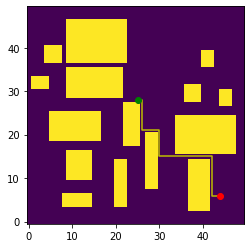

Number of steps taken in A* Path,  42
[  5.5   9.5   2.5   6.5 -19.   22. ]
[  1.5   6.5   6.5   9.5 -18.   22. ]
[  0.5   6.5   7.5   9.5 -17.   22. ]
[  4.5   3.5   0.5   8.5 -16.   22. ]
[  3.5   3.5   1.5   8.5 -15.   22. ]
[  2.5   3.5   2.5   8.5 -14.   22. ]
[  1.5   3.5   3.5   8.5 -13.   22. ]
[  0.5   3.5   4.5   8.5 -12.   22. ]
[ 13.5   6.5   0.5   9.5 -11.   22. ]
[ 12.5   6.5   1.5   9.5 -10.   22. ]
[11.5  6.5  2.5  9.5 -9.  22. ]
[10.5  6.5  3.5 43.5 -8.  22. ]
[ 9.5  6.5  4.5 43.5 -7.  22. ]
[ 8.5  6.5  5.5 43.5 -6.  22. ]
[ 7.5  6.5  6.5 43.5 -5.  22. ]
[ 6.5  6.5  7.5  1.5 -4.  22. ]
[ 5.5  6.5  8.5  1.5 -3.  22. ]
[ 4.5  6.5  9.5  1.5 -2.  22. ]
[ 3.5  6.5 10.5 43.5 -1.  22. ]
[ 2.5  6.5 11.5 11.5  0.  22. ]
[ 1.5  6.5 12.5 11.5  1.  22. ]
[ 0.5  6.5 13.5 11.5  2.  22. ]
[ 2.5  2.5  0.5  8.5  3.  22. ]
[ 1.5  2.5  1.5  8.5  4.  22. ]
[ 0.5  2.5  2.5  8.5  5.  22. ]
[ 4.5  6.5  0.5 22.5  6.  22. ]
[ 3.5  6.5  1.5 22.5  7.  22. ]
[ 2.5  6.5  2.5 22.5  8.  22. ]
[ 1.5 

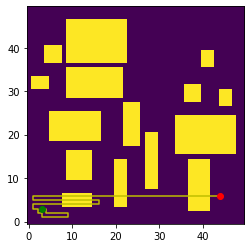

Number of steps taken in pred Path 95


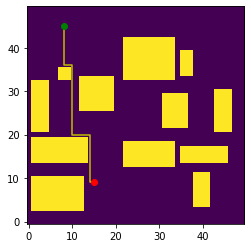

Number of steps taken in A* Path,  44
[22.5 16.5  2.5  9.5 -7.  36. ]
[ 1.5  9.5 23.5 16.5 -6.  36. ]
[ 0.5  9.5 24.5  4.5 -5.  36. ]
[11.5  6.5  0.5  1.5 -4.  36. ]
[10.5  6.5  1.5  1.5 -3.  36. ]
[ 9.5  6.5  2.5  1.5 -2.  36. ]
[ 8.5  6.5  3.5  1.5 -1.  36. ]
[ 7.5  6.5  4.5  1.5  0.  36. ]
[ 6.5  6.5  5.5  1.5  1.  36. ]
[ 5.5  6.5  6.5  1.5  2.  36. ]
[ 4.5  6.5  7.5  1.5  3.  36. ]
[ 3.5  6.5  8.5  1.5  4.  36. ]
[ 2.5  6.5  9.5  1.5  5.  36. ]
[ 1.5  6.5 10.5  1.5  6.  36. ]
[ 0.5  6.5 11.5  1.5  7.  36. ]
[ 5.5 11.5  2.5  0.5  7.  37. ]
[ 4.5 11.5  3.5  0.5  7.  38. ]
[ 3.5 11.5  4.5  0.5  7.  39. ]
[ 2.5 11.5  5.5  0.5  7.  40. ]
[ 1.5 11.5  6.5  0.5  7.  41. ]
[ 0.5 11.5  7.5  0.5  7.  42. ]
[ 2.5 48.5  0.5  1.5  7.  43. ]
[ 1.5 48.5  1.5  1.5  7.  44. ]
[47.5  1.5  2.5  1.5  6.  44. ]
[ 0.5  2.5  2.5 47.5  6.  43. ]
[ 7.5  1.5  0.5 10.5  6.  42. ]
[ 9.5  7.5  2.5  0.5  5.  42. ]
[ 2.5 46.5  0.5  3.5  5.  43. ]
[ 1.5 46.5  1.5  3.5  5.  44. ]
[45.5  1.5  4.5  1.5  4.  44. ]
[ 

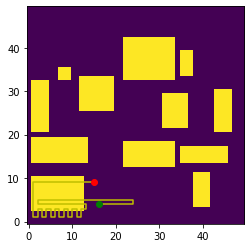

Number of steps taken in pred Path 101


In [58]:
# Test
pred_len = []
astar_len = []
n_test = 0
while n_test < 2:
    # TODO: Generalize to any map shape
    start = (random.randint(1,49), random.randint(1,49))
    goal = (random.randint(1,49), random.randint(1,49))
    arr, test_MAP = placeRandomRooms(map_size, minRoomSize=3, maxRoomSize=15, roomStep = 1, margin = 1, attempts = 100)
    # If path is available, get test info
    try:
        pred_path = test_on_new_map(test_MAP, arr, start, goal, clf)
        OccupancyGridMap(arr, 1).plot()
        plot_path(pred_path)
        pred_len.append(len(pred_path))
        print('Number of steps taken in pred Path', len(pred_path))
        astar_len.append(len(get_path(start, goal, arr, False)))
        n_test += 1
    except:
        # No path found
        continue

In [25]:
ls,_ = synthetic_sensor(train_MAP2, (9,40), direction=(0,0))
ls

(0, 0)


[41.0, 0.0, 9.0, 0.0]

In [245]:
def plot_path_with_lines(pred_path, MAP):
    '''
    Given predicted path nodes and map, 
    plot the path and the sensor readings for each node
    '''
    # Update node positions for shapely plotting
    pred_path = [(p[0]+0.5, p[1]+0.5) for p in pred_path]
    # Save filenames for GIF creation
    filenames=[]
    for i, node in enumerate(pred_path):
        # Create fig
        fig = plt.figure(frameon=False)
        fig.set_size_inches(6,6)
        plt.plot(*LineString(pred_path).xy)
        plt.scatter(*node, s=30, alpha=1.0)
        # Get lines from sensor 
        _, lines = synthetic_sensor(MAP, node)
        for index, l in enumerate(MAP): 
            if index != 0:
                plt.fill(*l.xy, alpha=1)
            else:
                plt.plot(*l.xy, alpha=1)
        for k, line in enumerate(lines):
            plt.plot(*line.xy, alpha=0.25)
        filenames.append('img_{}.png'.format(i))
        plt.savefig('img_{}.png'.format(i))
        plt.close()
    
    # Make GIF
    images = []
    for filename in filenames:
        images.append(imageio.imread(filename))
    imageio.mimsave('demo.gif', images)
        
plot_path_with_lines(pred_path, test_MAP)

In [244]:
# DL Solution ... not currently learning. 

import torch
class SensorData(torch.utils.data.Dataset):
    def __init__(self, df):
        self.df = df.copy()
        self.mms = MinMaxScaler()
        self.mms.fit(df.drop('out', axis=1).values)
    def __len__(self):
        return len(self.df)
    def __getitem__(self, idx):
        sample = self.df.iloc[idx]
        x = self.mms.transform(sample.drop('out').values.astype(np.float32).reshape(1,-1))
        y = sample['out']
        return (torch.from_numpy(x).double(), y)
    
ds = SensorData(df)
train_loader = torch.utils.data.DataLoader(ds,64,True, num_workers=0, pin_memory=True)

from resnet1d import ResNet1D
model = ResNet1D(1,64,3,3,1,24,4).cuda()

from tqdm.notebook import tqdm
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)
criterion = nn.CrossEntropyLoss()
if torch.cuda.is_available():
    model = model.cuda()
    criterion = criterion.cuda()

loss = 0
for i in range(20):
    ep_loss = 0
    for batch in tqdm(train_loader):
        model.train()
        x,y = batch[0].cuda().float(), batch[1].cuda()

        optimizer.zero_grad()
        
        out = model(x)
        loss = criterion(out,y.long())
        loss.backward()
        optimizer.step()
        ep_loss += loss.item()
        
    print(ep_loss/len(train_loader))
        

NameError: name 'nn' is not defined